In [0]:
%matplotlib inline

2か所修正
- 図はすべて図示（Generalization Gap も）
- `envs[3], envs[4]` を `envs[2], envs[1]` に修正

Fig.4 (Middle) は再現できず．Fig1 は重ねないと意味なし．

環境は4つ：
- 0, 1: 訓練用。10% と 20%
- 2: 検証用。15%
- 3:テスト用。90%

Flags:
	baseline: 0
	batch_size: 25000
	birm_v1_amount: 0.0
	birm_v2_amount: 1.0
	birm_v2_schedule: IRM
	birm_v2b: 0
	bound_fin: 5.5
	bound_init: 0.5
	bound_step_interval: 10
	bound_step_size: 0.1
	early_loss_mean: True
	erm_amount: 1.0
	eval_interval: 1
	grayscale_model: False
	hidden_dim: 256
	l2_regularizer_weight: 0.001
	labels01: 0
	loss_fn: BCE
	lr: 0.001
	lr_decay: 1.0
	lw_lr: 0.1
	momentum: 0.9
	n_restarts: 1
	n_val_sets: -1
	noise_amount: 0.0
	opt: Adam
	print_eval_intervals: True
	steps: 500
	train_set_size: 50000
	turn_off_ERM: 0
	use_linestyles: 0
	waterfall: 100
	waterfall_value: 10000
#####################
#####################
#####################
####### Start #######
birm_v2_amount: 0, waterfall_value: 0
#####################
#####################
#####################
Restart 0
step            train nll       train acc       train penalty   val nll         val acc         test acc     
0               0.66297         0.60548         0.00056         0.66237         0.

<Figure size 432x288 with 0 Axes>

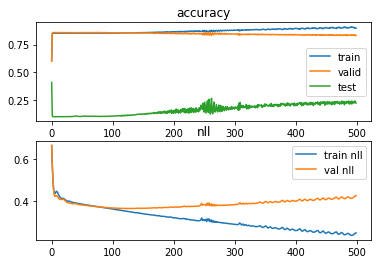

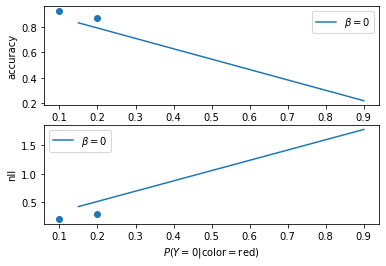

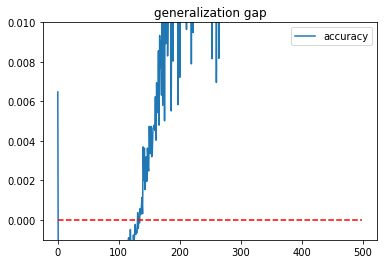

#####################
#####################
#####################
####### Start #######
birm_v2_amount: 1, waterfall_value: 100
#####################
#####################
#####################
Restart 0
step            train nll       train acc       train penalty   val nll         val acc         test acc     
0               0.70888         0.40672         0.00030         0.70678         0.42600         0.61540      
1               0.62169         0.83378         0.00411         0.62477         0.83020         0.11700      
2               0.55365         0.84838         0.01178         0.55996         0.84320         0.10300      
3               0.50155         0.84848         0.01468         0.50956         0.84320         0.10300      
4               0.46540         0.84848         0.01156         0.47383         0.84340         0.10300      
5               0.44589         0.84848         0.00715         0.45376         0.84340         0.10300      
6               0.44113   

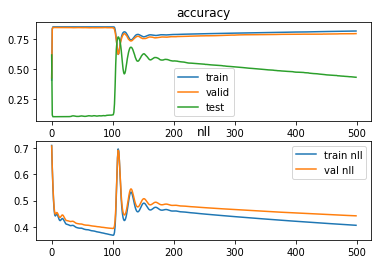

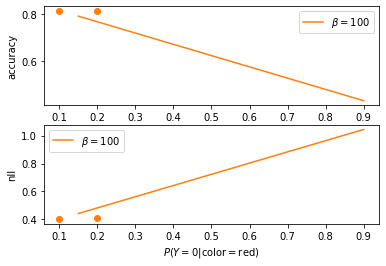

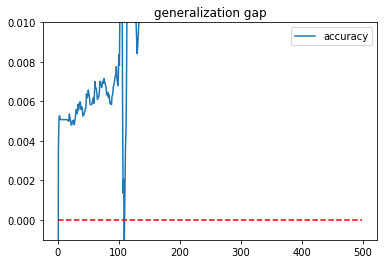

#####################
#####################
#####################
####### Start #######
birm_v2_amount: 1, waterfall_value: 10000
#####################
#####################
#####################
Restart 0
step            train nll       train acc       train penalty   val nll         val acc         test acc     
0               0.75150         0.34556         0.00442         0.74681         0.33980         0.58300      
1               0.66155         0.62336         0.00070         0.66205         0.63760         0.34140      
2               0.59212         0.84308         0.00696         0.59593         0.84340         0.11300      
3               0.53706         0.84864         0.01271         0.54266         0.84800         0.10320      
4               0.49414         0.84864         0.01400         0.50030         0.84800         0.10320      
5               0.46361         0.84864         0.01099         0.46925         0.84800         0.10320      
6               0.44600 

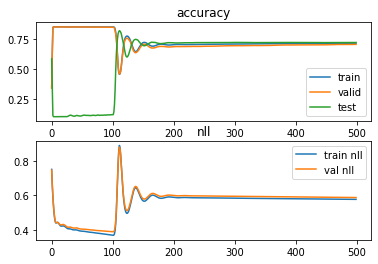

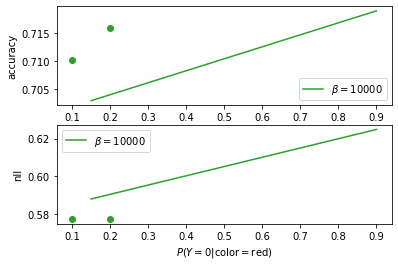

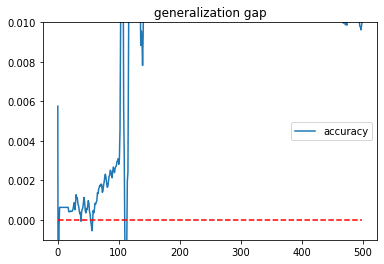

In [2]:
import argparse
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torch import nn, optim, autograd

from pylab import *
figure()

#top=0.989,
#bottom=0.1,
#left=0.124,
#right=0.992,
#hspace=0.146,
#wspace=0.2

def str2bool(v):
  return v.lower() in ("yes", "true", "t", "1")

use_cuda = torch.cuda.is_available()

parser = argparse.ArgumentParser(description='Colored MNIST')
parser.add_argument('--use_linestyles', type=int, default=0)
#
parser.add_argument('--hidden_dim', type=int, default=256)
parser.add_argument('--l2_regularizer_weight', type=float,default=0.001)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--lr_decay', type=float, default=1.)
parser.add_argument('--n_restarts', type=int, default=1)
parser.add_argument('--steps', type=int, default=500)
parser.add_argument('--grayscale_model', type=str2bool, default=False)
parser.add_argument('--batch_size', type=int, default=25000)
parser.add_argument('--train_set_size', type=int, default=50000)
parser.add_argument('--eval_interval', type=int, default=1)
parser.add_argument('--print_eval_intervals', type=str2bool, default=True)

parser.add_argument('--lw_lr', type=float, default=0.1)
parser.add_argument('--bound_init', type=float, default=0.5)
parser.add_argument('--bound_fin', type=float, default=5.5)
parser.add_argument('--bound_step_size', type=float, default=0.1)
parser.add_argument('--bound_step_interval', type=int, default=10)
parser.add_argument('--noise_amount', type=float, default=0.0)

parser.add_argument('--birm_v1_amount', type=float, default=0.0)
parser.add_argument('--birm_v2_amount', type=float, default=1.)
parser.add_argument('--birm_v2_schedule', type=str, default="IRM")
parser.add_argument('--waterfall', type=int, default=100)
parser.add_argument('--birm_v2b', type=int, default=0) # if 1, use entropy instead of MSE
parser.add_argument('--erm_amount', type=float, default=1.0)

#parser.add_argument('--fine_tune', type=int, default=1)

# added
parser.add_argument('--opt', type=str, default="Adam")
parser.add_argument('--momentum', type=float, default=.9)
parser.add_argument('--turn_off_ERM', type=int, default=0)
parser.add_argument('--loss_fn', type=str, default="BCE")
parser.add_argument('--baseline', type=int, default=0) # the var(Y)-var(Y^) one
parser.add_argument('--labels01', type=int, default=0)

parser.add_argument('--early_loss_mean', type=str2bool, default=True)

parser.add_argument('--n_val_sets', type=int, default=-1) #(actually this number + 1)
parser.add_argument('--waterfall_value', type=int, default=10**4) #(actually this number + 1)

flags = parser.parse_args([])

print('Flags:')
for k,v in sorted(vars(flags).items()):
  print("\t{}: {}".format(k, v))



if flags.n_val_sets > 0:
    assert flags.n_val_sets == 10
    n_val_sets = flags.n_val_sets
    val_noise_levels = 1. / n_val_sets * np.arange(n_val_sets + 1)
else:
    n_val_sets = 2
    val_noise_levels = [.15, .9]

for birm_v2_amount, waterfall_value in zip([0,1,1], [0,100,10000]):
    print("#####################")
    print("#####################")
    print("#####################")
    print("####### Start #######")
    print(f"birm_v2_amount: {birm_v2_amount}, waterfall_value: {waterfall_value}")
    print("#####################")
    print("#####################")
    print("#####################")


    num_batches = (flags.train_set_size // 2) // flags.batch_size

    # logging
    all_train_nlls = -1*np.ones((flags.n_restarts, flags.steps))
    all_train_accs = -1*np.ones((flags.n_restarts, flags.steps))
    all_val_nlls = -1*np.ones((flags.n_restarts, flags.steps))
    all_val_accs = -1*np.ones((flags.n_restarts, flags.steps))
    all_train_penalties = -1*np.ones((flags.n_restarts, flags.steps))
    all_test_accs = -1*np.ones((flags.n_restarts, flags.steps))

    def compute_softmax_negentropy(losses, stacked=False):
        if stacked:
            ps = F.softmax(losses)
        else:
            ps = F.softmax(torch.stack(losses))
        return torch.sum(ps*torch.log(ps))

    def set_lr(optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    final_train_accs = []
    final_test_accs = []
    highest_test_accs = []
    for restart in range(flags.n_restarts):
      print("Restart", restart)
      
      highest_test_acc = 0.0
      bound = flags.bound_init
      loss_weighting = .5 * torch.ones([2])
      if use_cuda:
        loss_weighting = loss_weighting.cuda()

      # Load MNIST, make train/val splits, and shuffle train set examples

      mnist = datasets.MNIST('~/datasets/mnist', train=True, download=True)
      mnist_train = (mnist.data[:50000], mnist.targets[:50000])
      mnist_val = (mnist.data[50000:], mnist.targets[50000:])

      rng_state = np.random.get_state()
      np.random.shuffle(mnist_train[0].numpy())
      np.random.set_state(rng_state)
      np.random.shuffle(mnist_train[1].numpy())

      # Build environments

      def make_environment(images, labels, e):
        def torch_bernoulli(p, size):
          return (torch.rand(size) < p).float()
        def torch_xor(a, b):
          return (a-b).abs() # Assumes both inputs are either 0 or 1
        # 2x subsample for computational convenience
        images = images.reshape((-1, 28, 28))[:, ::2, ::2]
        # Assign a binary label based on the digit; flip label with probability 0.25
        labels = (labels < 5).float()
        labels = torch_xor(labels, torch_bernoulli(0.25, len(labels)))
        # Assign a color based on the label; flip the color with probability e
        colors = torch_xor(labels, torch_bernoulli(e, len(labels)))
        # Apply the color to the image by zeroing out the other color channel
        images = torch.stack([images, images], dim=1)
        images[torch.tensor(range(len(images))), (1-colors).long(), :, :] *= 0
        if use_cuda:
          return {
            'images': (images.float() / 255.).cuda(),
            'labels': labels[:, None].cuda()
          }
        else:
          return {
            'images': (images.float() / 255.),
            'labels': labels[:, None]
          }

      # train envs
      envs = [
        make_environment(mnist_train[0][::2], mnist_train[1][::2], 0.2),
        make_environment(mnist_train[0][1::2], mnist_train[1][1::2], 0.1),
      ]

      # valid and test
      for n, noise in enumerate(val_noise_levels):
          envs.append(make_environment(mnist_val[0][n::n_val_sets], mnist_val[1][n::n_val_sets], noise))

      # Define and instantiate the model

      class MLP(nn.Module):
        def __init__(self):
          super(MLP, self).__init__()
          if flags.grayscale_model:
            lin1 = nn.Linear(14 * 14, flags.hidden_dim)
          else:
            lin1 = nn.Linear(2 * 14 * 14, flags.hidden_dim)
          lin2 = nn.Linear(flags.hidden_dim, flags.hidden_dim)
          lin3 = nn.Linear(flags.hidden_dim, 1)
          for lin in [lin1, lin2, lin3]:
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
          self._main = nn.Sequential(lin1, nn.ReLU(True), lin2, nn.ReLU(True), lin3)
        def forward(self, input):
          if flags.grayscale_model:
            out = input.view(input.shape[0], 2, 14 * 14).sum(dim=1)
          else:
            out = input.view(input.shape[0], 2 * 14 * 14)
          out = self._main(out)
          return out

      if use_cuda:
        mlp = MLP().cuda()
      else:
        mlp = MLP()

      # Define loss function helpers

      def mean_nll(logits, y):
        return nn.functional.binary_cross_entropy_with_logits(logits, y)

      def mean_accuracy(logits, y):
        preds = (logits > 0.).float()
        return ((preds - y).abs() < 1e-2).float().mean()

      def penalty(logits, y):
        if use_cuda:
          scale = torch.tensor(1.).cuda().requires_grad_()
        else:
          scale = torch.tensor(1.).requires_grad_()
        loss = mean_nll(logits * scale, y)
        grad = autograd.grad(loss, [scale], create_graph=True)[0]
        return torch.sum(grad**2)

      def mean_mse(logits, y):
        return ((logits - y)**2).mean()

      if flags.loss_fn == "BCE":
          compute_loss = mean_nll
      elif flags.loss_fn == "MSE":
          compute_loss = mean_mse
          if not flags.labels01:
              for env in envs: # move labels to -1,1
                  env["labels"] = 2 * (env["labels"] - .5)
      else:
          assert False



      # Train loop

      def pretty_print(*values):
        col_width = 13
        def format_val(v):
          if not isinstance(v, str):
            v = np.array2string(v, precision=5, floatmode='fixed')
          return v.ljust(col_width)
        str_values = [format_val(v) for v in values]
        print("   ".join(str_values))

      if flags.opt == "Adam":
        optimizer = optim.Adam(mlp.parameters(), lr=flags.lr, betas=[flags.momentum, .999])
      else:
        optimizer = optim.SGD(mlp.parameters(), lr=flags.lr, momentum=flags.momentum)

      pretty_print('step', 'train nll', 'train acc', 'train penalty', 'val nll', 'val acc', 'test acc')

      i = 0
      for step in range(flags.steps):
        #print(step)
        n = i % num_batches
        baselines = []
        for edx, env in enumerate(envs):
          #if edx != len(envs) - 1:
          if edx < 2: # training env       #!= len(envs) - 1 and edx != len(envs) - 2:
            logits = mlp(env['images'][n*flags.batch_size:(n+1)*flags.batch_size])
            baselines.append(torch.var(env['labels']) - torch.var(logits))
            env['nll'] = compute_loss(logits, env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
            env['acc'] = mean_accuracy(logits, env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
            env['penalty'] = penalty(logits, env['labels'][n*flags.batch_size:(n+1)*flags.batch_size])
          else: # valid env
            logits = mlp(env['images'])
            env['nll'] = compute_loss(logits, env['labels'])
            env['acc'] = mean_accuracy(logits, env['labels'])
            env['penalty'] = penalty(logits, env['labels'])
        i+=1

        train_nll = torch.stack([envs[0]['nll'], envs[1]['nll']]).mean()
        train_acc = torch.stack([envs[0]['acc'], envs[1]['acc']]).mean()
        train_penalty = torch.stack([envs[0]['penalty'], envs[1]['penalty']]).mean()

        if use_cuda:
          weight_norm = torch.tensor(0.).cuda()
        else:
          weight_norm = torch.tensor(0.)
        for w in mlp.parameters():
          weight_norm += w.norm().pow(2)

        noise = (torch.randn(2, flags.batch_size) * flags.noise_amount) + 1.0
        if use_cuda:
          noise = noise.cuda()

        loss1 = envs[0]['nll']
        loss2 = envs[1]['nll']

        if step < -1:
          bounds = torch.tensor([flags.bound_init, 1-flags.bound_init])
        elif loss1 > loss2:
          bounds = torch.tensor([bound, 1-bound]) 
        else:
          bounds = torch.tensor([1-bound, bound])

        if use_cuda:
          bounds = bounds.cuda()
        loss_weighting = (1 - flags.lw_lr) * loss_weighting + flags.lw_lr * bounds
        

        if flags.early_loss_mean:
          loss1 = loss1.mean()
          loss2 = loss2.mean()

        loss = 0.0

        if flags.baseline:
            print((baselines[0] - baselines[1]).cpu().detach().numpy())
            loss1 -= baselines[0]
            loss2 -= baselines[1]

        loss += flags.birm_v1_amount * ((loss_weighting[0] * loss1 * noise[0]).mean() + (loss_weighting[1] * loss2 * noise[1])).mean()
        if flags.birm_v2_schedule == "IRM":
            #if step > 2*flags.waterfall:
            #    if flags.birm_v2b:
            #        loss += flags.birm_v3_amount * 10**4  * (compute_softmax_negentropy(loss1, loss2))
            #    else:
            #        loss += flags.birm_v2_amount * 10**4 * ((loss1 * noise[0]).mean() - (loss2 * noise[1]).mean()) ** 2
            if step > flags.waterfall:
                if flags.birm_v2b:
                    loss += birm_v2_amount * waterfall_value  * (compute_softmax_negentropy(loss1, loss2))
                else:
                    loss += birm_v2_amount * waterfall_value * ((loss1 * noise[0]).mean() - (loss2 * noise[1]).mean()) ** 2
            else:
                if flags.birm_v2b:
                    loss += birm_v2_amount * (compute_softmax_negentropy(loss1, loss2))
                else:
                    loss += birm_v2_amount * ((loss1 * noise[0]).mean() - (loss2 * noise[1]).mean()) ** 2
        else:
            if flags.birm_v2b:
                loss += birm_v2_amount * float(flags.birm_v2_schedule)**step * (compute_softmax_negentropy(loss1, loss2))
            else:
                loss += birm_v2_amount * float(flags.birm_v2_schedule)**step * ((loss1 * noise[0]).mean() - (loss2 * noise[1]).mean()) ** 2

        if step < 201 or not flags.turn_off_ERM:
            loss += flags.erm_amount * (loss1 + loss2)


        loss += flags.l2_regularizer_weight * weight_norm
        if 0:#step % 100 == 0:
            print(loss.detach().cpu().numpy())

        if step > flags.waterfall and waterfall_value > 0:
            loss /= waterfall_value
        #if step > 2*flags.waterfall:
        #    loss /= 10**4
        
        loss *= flags.lr_decay**step

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_acc = envs[2]['acc']
        val_nll = envs[2]['nll']
        test_acc = envs[3]['acc']

        if step % flags.bound_step_interval == 9 and bound < flags.bound_fin:
          bound += flags.bound_step_size

        if step % flags.eval_interval == 0:
          train_acc_scalar = train_acc.detach().cpu().numpy()
          test_acc_scalar = test_acc.detach().cpu().numpy()
          all_train_nlls[restart, step] = train_nll.detach().cpu().numpy()
          all_train_accs[restart, step] = train_acc.detach().cpu().numpy()
          all_train_penalties[restart, step] = train_penalty.detach().cpu().numpy()
          all_val_nlls[restart, step] = val_nll.detach().cpu().numpy()
          all_val_accs[restart, step] = val_acc.detach().cpu().numpy()
          all_test_accs[restart, step] = test_acc.detach().cpu().numpy()
          if flags.print_eval_intervals:
            pretty_print(
              np.int32(step),
              train_nll.detach().cpu().numpy(),
              train_acc.detach().cpu().numpy(),
              train_penalty.detach().cpu().numpy(),
              val_nll.detach().cpu().numpy(),
              val_acc.detach().cpu().numpy(),
              test_acc.detach().cpu().numpy()
            )
            #print("bound: ", bound)
            #print("loss1", loss1, "loss2",  loss2)
            #print("loss_weighting: ", loss_weighting)
          if (train_acc_scalar >= test_acc_scalar) and (test_acc_scalar > highest_test_acc):
            highest_test_acc = test_acc_scalar

      print('highest test acc this run:', highest_test_acc)

      final_train_accs.append(train_acc.detach().cpu().numpy())
      final_test_accs.append(test_acc.detach().cpu().numpy())
      highest_test_accs.append(highest_test_acc)
      print('Final train acc (mean/std across restarts so far):')
      print(np.mean(final_train_accs), np.std(final_train_accs))
      print('Final test acc (mean/std across restarts so far):')
      print(np.mean(final_test_accs), np.std(final_test_accs))
      print('Highest test acc (mean/std across restarts so far):')
      print(np.mean(highest_test_accs), np.std(highest_test_accs))

    np.save('gen_gap.npy', all_train_accs.mean(0) - all_val_accs.mean(0))

    from pylab import *
    # if 0:
    figure()
    subplot(211)
    title('accuracy')
    plot(all_train_accs.mean(0), label='train')
    plot(all_val_accs.mean(0), label='valid')
    plot(all_test_accs.mean(0), label='test')
    legend()
    subplot(212)
    title('nll')
    plot(all_train_nlls.mean(0), label='train nll')
    plot(all_val_nlls.mean(0), label='val nll')
    legend()
    plt.show();


    color_lookup = {0.: plt.get_cmap('tab10').colors[0],100.: plt.get_cmap('tab10').colors[1],10000.: plt.get_cmap('tab10').colors[2]}

    if flags.use_linestyles:
        linestyles = {0.: '-', 100.: '--', 10000.:'dotted'}
    else:
        linestyles = {0.: '-', 100.: '-', 10000.:'-'}

    #figure()
    subplot(211)
    ylabel('accuracy')
    #for n, noise in enumerate(val_noise_levels):
    #    plot(envs[2+n]['acc'], label='noise_level='+str(noise))
    plot(val_noise_levels, [envs[2+n]['acc'].detach().cpu().numpy() for n in range(len(val_noise_levels))], label=r'$\beta=$' + str(waterfall_value), color=color_lookup[waterfall_value], linestyle=linestyles[waterfall_value])
    # TODO: hardcoded
    plot(.1, envs[1]['acc'].detach().cpu().numpy(), 'o', color=color_lookup[waterfall_value])
    plot(.2, envs[0]['acc'].detach().cpu().numpy(), 'o', color=color_lookup[waterfall_value])
    #xlabel('noise_level')
    legend()
    #
    subplot(212)
    ylabel('nll')
    #for n, noise in enumerate(val_noise_levels):
    plot(val_noise_levels, [envs[2+n]['nll'].detach().cpu().numpy() for n in range(len(val_noise_levels))], label=r'$\beta=$' + str(waterfall_value), color=color_lookup[waterfall_value], linestyle=linestyles[waterfall_value])
    plot(.1, envs[1]['nll'].detach().cpu().numpy(), 'o', color=color_lookup[waterfall_value])
    plot(.2, envs[0]['nll'].detach().cpu().numpy(), 'o', color=color_lookup[waterfall_value])
    xlabel(r'$P(Y=0|\mathrm{color=red})$')
    legend()
    plt.show();



    ##########
    # Generalization Gap も図示
    ##########
    # if 0:
    figure()
    title('generalization gap')
    plot(all_train_accs.mean(0) - all_val_accs.mean(0), label='accuracy')
    plot([0 for x in range(flags.steps)], 'r--')
    ylim(-.001, .01)
    #plot(-(all_train_nlls.mean(0) - all_val_nlls.mean(0)), label='nll')
    legend()
    plt.show();
